In [43]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
from data_processing_xu import get_data_2dprojection
import os
import matplotlib.pyplot as plt

In [5]:
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from tqdm import tqdm_notebook
EPS = 1e-7

def lat(x,y,z):
    return np.arcsin(z/np.sqrt(x**2 + y**2 + z**2))

def lon(x,y,z):
    return np.arctan2(y,x)


def get_data_2dprojection_lat_lon(lpmt_hits, spmt_hits, pos, true_info, edge_size1=111, edge_size2=226, use_spmt=False, time=None):
    """
    Transfer data into 2d projection (moll) with 1 channel
    Params:
    ..., 
    edge_size : int - projection image size, 
    use_spmt : bool 
    
    Returns:
    data_lpmt: pd.DataFrame
    event_to_id: dict
    """
    channels = 1
    if time == 'min':
        channels = 2
        
    pos['lat'] = list(map(lambda el: lat(el[0],el[1],el[2]), zip(pos['pmt_x'], pos['pmt_y'], pos['pmt_z'])))
    pos['lon'] = list(map(lambda el: lon(el[0],el[1],el[2]), zip(pos['pmt_x'], pos['pmt_y'], pos['pmt_z'])))
    print("Make projection")
    if use_spmt:
        lpmt_hits = pd.concat([lpmt_hits, spmt_hits])
    merged_hits = pd.merge(lpmt_hits, pos, left_on='pmtID', right_on='pmt_id')
    EPS = 1e-7
    mol0min = -np.pi/2 - EPS
    mol0max = np.pi/2 + EPS
    mol1min = -np.pi - EPS
    mol1max = np.pi + EPS
    # Fit coordinates
    merged_hits['mol0i'] = round((merged_hits['lat'] - mol0min) / (mol0max - mol0min) * (edge_size1 - 1)).astype(int)
    merged_hits['mol1i'] = round((merged_hits['lon'] - mol1min) / (mol1max - mol1min) * (edge_size2 - 1)).astype(int)
    
    n = len(lpmt_hits['event'].unique())
    data_lpmt = np.zeros((n, edge_size1, edge_size2, channels))
    
    event_to_id = {x:y for y, x in enumerate(sorted(merged_hits['event'].unique()))}
    print("Starting cycle...")
    if time is None:
        for event, mol0i, mol1i in tqdm_notebook(zip(merged_hits['event'], merged_hits['mol0i'], merged_hits['mol1i'])):
            data_lpmt[event_to_id[event]][mol0i, mol1i] += 1
    elif time == 'min':
        data_lpmt[:,:,:,1] = -EPS
        # Calculate min time for each event
        ev_min = merged_hits[['event', 'hitTime']].groupby('event').min()
        event2min = {id_: min_ for id_, min_ in zip(ev_min.index, ev_min.hitTime)}
        ev_len = merged_hits[['event', 'hitTime']].groupby('event').count()
        event2len = {id_: len_ for id_, len_ in zip(ev_len.index, ev_len.hitTime)}
        
        for event, mol0i, mol1i, time in tqdm_notebook(zip(merged_hits['event'], merged_hits['mol0i'], merged_hits['mol1i'], merged_hits['hitTime'])):
            event_id = event_to_id[event]
            data_lpmt[event_id][mol0i, mol1i][0] += 1 * 1000 / event2len[event]
            event_min = event2min[event]
            cur_min = data_lpmt[event_id][mol0i, mol1i][1] 
            if cur_min < 0 or cur_min > (time/100 - event_min/100):
                data_lpmt[event_id][mol0i, mol1i][1] = (time - event_min)/100
    return data_lpmt, event_to_id


In [6]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv') 
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [10]:
rg = np.arange(0,100000,15000)

In [7]:
MAXR=17200

In [8]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'

In [11]:
for start, end  in zip(rg[:-1], rg[1:]):
    data_lpmt, event_to_id = get_data_2dprojection_lat_lon(tr_lpmt_hits[(tr_lpmt_hits['event'] >= start) & (tr_lpmt_hits['event'] < end)
                                                                & (tr_lpmt_hits['isDN'] == False)], 
                                                tr_spmt_hits[(tr_spmt_hits['event'] >= start) & (tr_spmt_hits['event'] < end) 
                                                            & (tr_spmt_hits['isDN'] == False)], 
                                                tr_pos, 
                                                tr_true_info[(tr_true_info.R<=MAXR) 
                                                             & (tr_true_info['evtID'] >= start) 
                                                             & (tr_true_info['evtID'] < end)],
                                                use_spmt=False,
                                                time='min')
    np.save(LTRAIN + '1_' + str(start) + 'without_noise' + '_time_min_xu', data_lpmt)

Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...


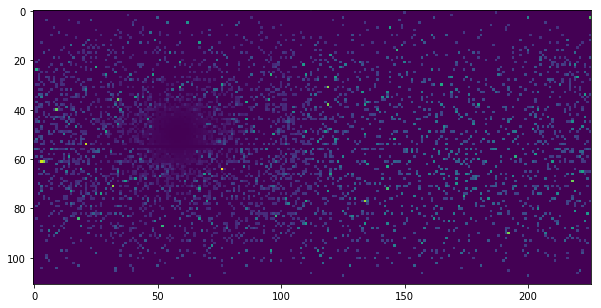

In [16]:
fig = plt.figure(figsize=(10,8))
plt.imshow(data_lpmt[50][:,:,1])

In [17]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [19]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [20]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [21]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [22]:
model = Sequential()
model.add(L.Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(1))

In [23]:
from keras.optimizers import Adam
opt = Adam(decay=1e-4)
model.compile(loss='mean_squared_error', optimizer=opt)
model.build(input_shape=(None, 111,226,2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 109, 224, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 112, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 110, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 24, 256)       295168    
__________

In [24]:
logdir = 'log_YuXu_lat.csv'

In [25]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(logdir, append=True, separator=';')

In [26]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [27]:
epochs = [5,3,3,1,1,1,1]

In [28]:
import gc
for i in range(7):
    for start, end in zip(rg[:-1], rg[1:]):
        data_lpmt = np.load(LTRAIN + '1_' + str(start) +'without_noise_time_min_xu_l'+ '.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start) 
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt = data_lpmt[mask]
        y_val = ys[mask][['E']].values
        
        X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(X_train, y_train, batch_size=32, 
                epochs=epochs[i],
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

Train on 11020 samples, validate on 2756 samples
Epoch 1/5
11020/11020 [==============================] - 51s 5ms/step - loss: 1.8868 - val_loss: 0.1686
Epoch 2/5
11020/11020 [==============================] - 47s 4ms/step - loss: 0.1675 - val_loss: 0.1364
Epoch 3/5
11020/11020 [==============================] - 46s 4ms/step - loss: 0.1140 - val_loss: 0.0882
Epoch 4/5
11020/11020 [==============================] - 47s 4ms/step - loss: 0.1013 - val_loss: 0.1679
Epoch 5/5
11020/11020 [==============================] - 46s 4ms/step - loss: 0.0836 - val_loss: 0.0570
Train on 10988 samples, validate on 2747 samples
Epoch 1/5
10988/10988 [==============================] - 47s 4ms/step - loss: 0.0565 - val_loss: 0.0559
Epoch 2/5
10988/10988 [==============================] - 48s 4ms/step - loss: 0.0633 - val_loss: 0.0280
Epoch 3/5
10988/10988 [==============================] - 47s 4ms/step - loss: 0.0526 - val_loss: 0.0291
Epoch 4/5
10988/10988 [==============================] - 46s 4ms/step 

Train on 11036 samples, validate on 2760 samples
Epoch 1/1
11036/11036 [==============================] - 42s 4ms/step - loss: 0.0160 - val_loss: 0.0160
Train on 11064 samples, validate on 2767 samples
Epoch 1/1
11064/11064 [==============================] - 41s 4ms/step - loss: 0.0137 - val_loss: 0.0203
Train on 10959 samples, validate on 2740 samples
Epoch 1/1
10959/10959 [==============================] - 41s 4ms/step - loss: 0.0165 - val_loss: 0.0146
Train on 11020 samples, validate on 2756 samples
Epoch 1/1
11020/11020 [==============================] - 41s 4ms/step - loss: 0.0194 - val_loss: 0.0140
Train on 10988 samples, validate on 2747 samples
Epoch 1/1
10988/10988 [==============================] - 41s 4ms/step - loss: 0.0172 - val_loss: 0.0141
Train on 11041 samples, validate on 2761 samples
Epoch 1/1
11041/11041 [==============================] - 41s 4ms/step - loss: 0.0179 - val_loss: 0.0178
Train on 11036 samples, validate on 2760 samples
Epoch 1/1
11036/11036 [==========

In [29]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'

In [13]:
MAXR=17200

In [14]:
for start, end  in zip(rg[:-1], rg[1:]):
    data_lpmt, event_to_id = get_data_2dprojection(tr_lpmt_hits[(tr_lpmt_hits['event'] >= start) & (tr_lpmt_hits['event'] < end)
                                                                & (tr_lpmt_hits['isDN'] == False)], 
                                                tr_spmt_hits[(tr_spmt_hits['event'] >= start) & (tr_spmt_hits['event'] < end) 
                                                            & (tr_spmt_hits['isDN'] == False)], 
                                                tr_pos, 
                                                tr_true_info[(tr_true_info.R<=MAXR) 
                                                             & (tr_true_info['evtID'] >= start) 
                                                             & (tr_true_info['evtID'] < end)],
                                                use_spmt=True,
                                                time='min')
    np.save(LTRAIN + '1_' + str(start) + 'without_noise' + '_time_min_xu', data_lpmt)

Make projection
Starting cycle...


Make projection
Starting cycle...


Make projection
Starting cycle...


Make projection
Starting cycle...


Make projection
Starting cycle...


Make projection
Starting cycle...


In [15]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [16]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [17]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [18]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [34]:
model = Sequential()
model.add(L.Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(1))

In [35]:
from keras.optimizers import Adam

In [36]:
opt = Adam(decay=1e-4)

In [37]:
model.compile(loss='mean_squared_error', optimizer=opt)

In [38]:
model.build(input_shape=(None, 111,226,2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 109, 224, 32)      608       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 112, 32)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 110, 64)       18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 55, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 26, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 24, 256)       295168    
__________

In [39]:
logdir = 'log_YuXu.csv'

In [40]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(logdir, append=True, separator=';')

In [41]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [43]:
epochs = [5,5,5,5,1,1,1]

In [45]:
import gc
for i in range(7):
    for start, end in zip(rg[:-1], rg[1:]):
        data_lpmt = np.load(LTRAIN + '1_' + str(start) +'without_noise_time_min_xu'+ '.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start) 
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt = data_lpmt[mask]
        y_val = ys[mask][['E']].values
        
        X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(X_train, y_train, batch_size=32, 
                epochs=epochs[i],
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

Train on 11020 samples, validate on 2756 samples
Epoch 1/5
11020/11020 [==============================] - 43s 4ms/step - loss: 2.5812 - val_loss: 0.0330
Epoch 2/5
11020/11020 [==============================] - 38s 3ms/step - loss: 0.0882 - val_loss: 0.2847
Epoch 3/5
11020/11020 [==============================] - 38s 3ms/step - loss: 0.0639 - val_loss: 0.2206
Epoch 4/5
11020/11020 [==============================] - 38s 3ms/step - loss: 0.0667 - val_loss: 0.0510
Epoch 5/5
11020/11020 [==============================] - 38s 3ms/step - loss: 0.0541 - val_loss: 0.0409
Train on 10988 samples, validate on 2747 samples
Epoch 1/5
10988/10988 [==============================] - 39s 4ms/step - loss: 0.0497 - val_loss: 0.0443
Epoch 2/5
10988/10988 [==============================] - 38s 3ms/step - loss: 0.0696 - val_loss: 0.0316
Epoch 3/5
10988/10988 [==============================] - 39s 4ms/step - loss: 0.0561 - val_loss: 0.0264
Epoch 4/5
10988/10988 [==============================] - 39s 4ms/step 

10959/10959 [==============================] - 37s 3ms/step - loss: 0.0120 - val_loss: 0.0116


In [ ]:
reduce_lr = keras.callbacks.LearningRateScheduler(lambda it: 1e-5, verbose=0)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
cs = pd.read_csv(logdir, sep=';')

(0, 0.3)

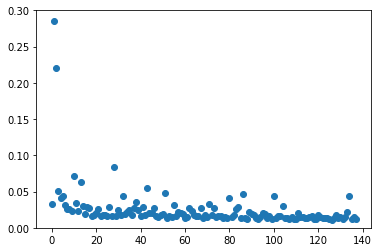

In [48]:
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,0.3)

(0, 0.5)

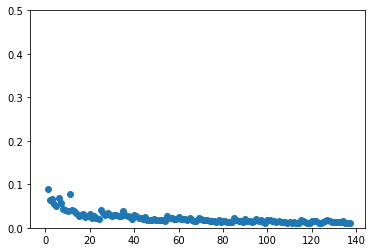

In [49]:
plt.scatter(np.arange(0, cs.shape[0]), cs['loss'].values)
plt.ylim(0,0.5)

In [ ]:
model.save_weights('ResNet70.h5')

In [ ]:
with open("ResNet70.json", "w") as json_file:
    json_file.write(model.to_json())

In [50]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [51]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])

In [52]:
test_resultsE.mean()

0.011585442767695856

(-0.05, 0.05)

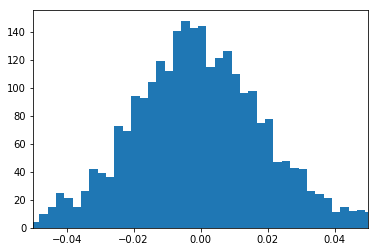

In [53]:
plt.hist((preds[:,0] - y_test[:,0])/y_test[:,0], bins=200)
plt.xlim((-0.05,0.05))

In [33]:
from tqdm import tqdm

In [34]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [38]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, use_spmt=False,
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_time_YuXu_ll.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_YuXu_ll.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            print("Compute...")
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                data_lpmt, event_to_id = get_data_2dprojection_lat_lon(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                    use_spmt=use_spmt,
                                    time='min')
                np.save(test_dir+str(energy)+'data_lpmt_time_YuXu_ll', data_lpmt)
            else:
                data_lpmt, event_to_id = get_data_2dprojection_lat_lon(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                    use_spmt=True)
                np.save(test_dir+str(energy)+'data_lpmt_YuXu_ll', data_lpmt)
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        preds = np.maximum(model.predict(data_lpmt), 0)
        y_test = true_info[test_column]
        print(y_test.mean())
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        # in percents
        sigmas[energy] = np.std(preds - y_test.mean()) / (energy + CONST)
    print("+")
    return sigmas, MSEs, predictions

In [39]:
sigmas, MSEs, predictions = test_sigmas(model, use_spmt=False, time=True, recompute=True)


  0%|          | 0/10 [00:00<?, ?it/s]

Compute...
Make projection
Starting cycle...



 10%|█         | 1/10 [00:17<02:37, 17.54s/it]

0.5109988999999999
Compute...
Make projection
Starting cycle...



 20%|██        | 2/10 [00:48<02:51, 21.43s/it]

1.5109988697622994
Compute...
Make projection
Starting cycle...



 30%|███       | 3/10 [01:32<03:18, 28.30s/it]

2.5109990065502177
Compute...
Make projection
Starting cycle...



 40%|████      | 4/10 [02:31<03:45, 37.54s/it]

3.5109988987951803
Compute...
Make projection
Starting cycle...



 50%|█████     | 5/10 [03:44<04:01, 48.28s/it]

4.510998806956522
Compute...
Make projection
Starting cycle...



 60%|██████    | 6/10 [05:13<04:02, 60.51s/it]

5.510998686870312
Compute...
Make projection
Starting cycle...



 70%|███████   | 7/10 [06:54<03:37, 72.65s/it]

6.510998666593649
Compute...
Make projection
Starting cycle...



 80%|████████  | 8/10 [08:40<02:44, 82.42s/it]

7.510998798899285
Compute...
Make projection
Starting cycle...



 90%|█████████ | 9/10 [10:35<01:32, 92.37s/it]

8.510999212171052
Compute...
Make projection
Starting cycle...



100%|██████████| 10/10 [12:48<00:00, 104.39s/it]

9.510998837121212
+


In [40]:
sigmas, MSEs

({0: 0.053916166585718815,
  1: 0.03643840566115374,
  2: 0.02948516976115405,
  3: 0.02765475644038602,
  4: 0.02171065805206162,
  5: 0.020480393987286332,
  6: 0.023320678019924265,
  7: 0.018833693171700645,
  8: 0.017531766143085104,
  9: 0.018963850833917183},
 {0: 0.0069553942783653604,
  1: 0.006271046692936007,
  2: 0.015112403637028416,
  3: 0.018532018694460476,
  4: 0.017688744213495634,
  5: 0.020462582027916836,
  6: 0.029405630047082916,
  7: 0.025622880837994765,
  8: 0.028855586808029767,
  9: 0.036545570524340924})

In [41]:
a = 2.8
b=0.59
c=0


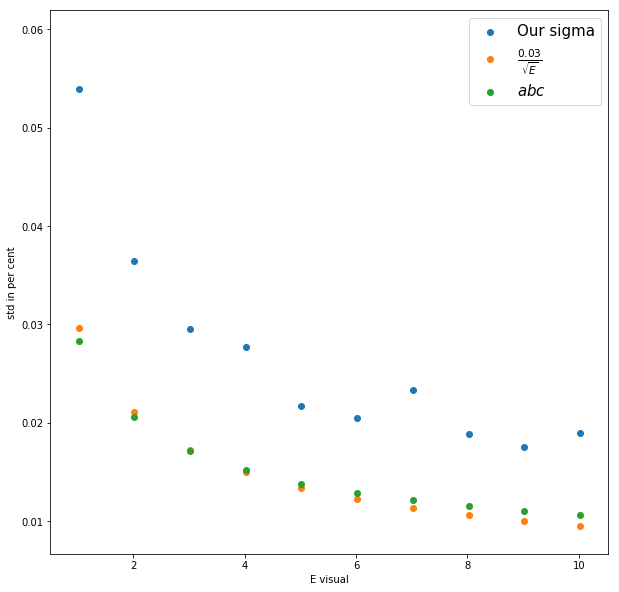

In [42]:
# Plot sigmas
Evis = np.array([en + 1.022  for en in range(10)])
Perc_sigmas = [sigmas[en] for en in range(10)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
plt.scatter(Evis, Perc_sigmas, label='Our sigma')
plt.scatter(Evis, perc_3_sqrt_E, label=r'$\frac{0.03}{\sqrt{E}}$')
plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std in per cent")
plt.xlabel("E visual")
plt.legend(fontsize=15)